In [1]:
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
import calendar
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics import root_mean_squared_error as rmse, mean_absolute_error as mae, r2_score as r2, mean_absolute_percentage_error as mape

import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras_tuner.tuners import RandomSearch

In [2]:
restaurants = pd.read_csv('restaurants.csv')
sales = pd.read_csv('sales.csv')
items = pd.read_csv('items.csv')

In [3]:
print("Restaurants DataFrame")
print(restaurants.head())

print("\n\nSales DataFrame")
print(sales.head())

print("\n\nItem DataFrame")
print(items.head())

Restaurants DataFrame
   id            name
0   1     Bob's Diner
1   2  Beachfront Bar
2   3     Sweet Shack
3   4        Fou Cher
4   5     Corner Cafe


Sales DataFrame
         date  item_id  item_count   price
0  01-01-2019        3           2   58.44
1  01-01-2019        4          22  581.24
2  01-01-2019       12           7   34.09
3  01-01-2019       13          12   50.16
4  01-01-2019       16         136  436.56


Item DataFrame
   id  store_id                               name  kcal   cost
0   1         4                     Chocolate Cake   554   6.71
1   2         4  Breaded Fish with Vegetables Meal   772  15.09
2   3         1                  Sweet Fruity Cake   931  29.22
3   4         1    Amazing Steak Dinner with Rolls   763  26.42
4   5         5                          Milk Cake   583   6.07


In [4]:
# As date column in Sales is object(meaning it has some string values in it), let's make it a date
sales['date'] = pd.to_datetime(sales['date'], format='mixed')

print('Data type of Sales')
print(sales.dtypes)

Data type of Sales
date          datetime64[ns]
item_id                int64
item_count             int64
price                float64
dtype: object


In [5]:
print('Shapes of the DataFrame')

print("\n\nShape of the Restuarant's DataFrame")
print(restaurants.shape)

print("\n\nShape of the Sales's DataFrame")
print(sales.shape)

print("\n\nShape of the Items's DataFrame")
print(items.shape)

Shapes of the DataFrame


Shape of the Restuarant's DataFrame
(6, 2)


Shape of the Sales's DataFrame
(109600, 4)


Shape of the Items's DataFrame
(100, 5)


In [6]:
print('Looking for dupicates in the Dataset')

print(f"\n\nDuplicates in Restuarants's DataFrame: {restaurants.duplicated().sum()}")

print(f"\n\nDuplicates in Sales's DataFrame: {sales.duplicated().sum()}")

print(f"\n\nDuplicates in Items's DataFrame: {items.duplicated().sum()}")

Looking for dupicates in the Dataset


Duplicates in Restuarants's DataFrame: 0


Duplicates in Sales's DataFrame: 0


Duplicates in Items's DataFrame: 0


In [7]:
print('Looking for Null Vales in the Dataset')

print("\n\nNull Values in Restuarants DataFrame")
print(restaurants.isnull().sum())

print("\n\nNull Values in Sales DataFrame")
print(sales.isnull().sum())

print("\n\nNull Values in Items DataFrame")
print(items.isnull().sum())

Looking for Null Vales in the Dataset


Null Values in Restuarants DataFrame
id      0
name    0
dtype: int64


Null Values in Sales DataFrame
date          0
item_id       0
item_count    0
price         0
dtype: int64


Null Values in Items DataFrame
id          0
store_id    0
name        0
kcal        0
cost        0
dtype: int64


In [8]:
# Merging DataFrames

merged_data = pd.merge(sales, items, left_on='item_id', right_on='id', how='left')

new_df = pd.merge(merged_data, restaurants, left_on='store_id', right_on='id')

In [9]:
new_df.columns

Index(['date', 'item_id', 'item_count', 'price', 'id_x', 'store_id', 'name_x',
       'kcal', 'cost', 'id_y', 'name_y'],
      dtype='object')

In [10]:
new_df.rename(columns = {"name_x" : "item_name", "name_y" : "restaurants_name"}, inplace=True)

new_df.drop(columns = ['id_x', 'id_y', 'cost'], inplace=True)

In [11]:
items[items['id'] == 16]

,id,store_id,name,kcal,cost
15,16,1,Frozen Milky Smoothy,284,3.21


In [12]:
new_df.head()

,date,item_id,item_count,price,store_id,item_name,kcal,restaurants_name
0,2019-01-01,3,2,58.44,1,Sweet Fruity Cake,931,Bob's Diner
1,2019-01-01,4,22,581.24,1,Amazing Steak Dinner with Rolls,763,Bob's Diner
2,2019-01-01,12,7,34.09,1,Fantastic Sweet Cola,478,Bob's Diner
3,2019-01-01,13,12,50.16,1,Sweet Frozen Soft Drink,490,Bob's Diner
4,2019-01-01,16,136,436.56,1,Frozen Milky Smoothy,284,Bob's Diner


Exploratory Data Analysis (EDA)

In [13]:
new_df.dtypes

date                datetime64[ns]
item_id                      int64
item_count                   int64
price                      float64
store_id                     int64
item_name                   object
kcal                         int64
restaurants_name            object
dtype: object

In [14]:
new_df.describe()

,date,item_id,item_count,price,store_id,kcal
count,109600,109600.000000,109600.000000,109600.000000,109600.00000,109600.000000
mean,2020-07-01 12:00:00,50.500000,6.339297,58.428271,3.52000,536.730000
min,2019-01-01 00:00:00,1.000000,0.000000,0.000000,1.00000,78.000000
25%,2019-10-01 18:00:00,25.750000,0.000000,0.000000,2.00000,406.250000
50%,2020-07-01 12:00:00,50.500000,0.000000,0.000000,4.00000,572.500000
75%,2021-04-01 06:00:00,75.250000,0.000000,0.000000,5.00000,638.250000
max,2021-12-31 00:00:00,100.000000,570.000000,2224.800000,6.00000,1023.000000
std,NaN,28.866202,30.003728,214.812200,1.69989,201.200165


In [15]:
new_df.isnull().sum()

date                0
item_id             0
item_count          0
price               0
store_id            0
item_name           0
kcal                0
restaurants_name    0
dtype: int64

In [16]:
# Total Revenue
print(f"Total Revenue: {new_df['price'].sum()}")

Total Revenue: 6403738.449999999


In [17]:
# Total Items Sold
print(f"Total Items Sold: {new_df['item_count'].sum()}")

Total Items Sold: 694787


In [18]:
# Average Price
print(f"Average Price: {new_df['price'].mean()}")

Average Price: 58.42827052919707


In [19]:
# Best Selling Items
best_selling_items = new_df.groupby('item_id')['item_count'].sum().nlargest(5)
for id_, count in zip(best_selling_items.index, best_selling_items.values):
    print(f"The best selling item is {items[items['id'] == id_]['name'].iloc[0]} with item id {id_} and total count of {count}")

The best selling item is Strawberry Smoothy with item id 19 and total count of 236337
The best selling item is Frozen Milky Smoothy with item id 16 and total count of 102990
The best selling item is Amazing pork lunch with item id 76 and total count of 61043
The best selling item is Mutton Dinner with item id 38 and total count of 52772
The best selling item is Orange Juice with item id 9 and total count of 43874


Understanding Sales Pattern

In [20]:
# Overall Sales Data
dw_df = new_df.groupby('date')['item_count'].sum()

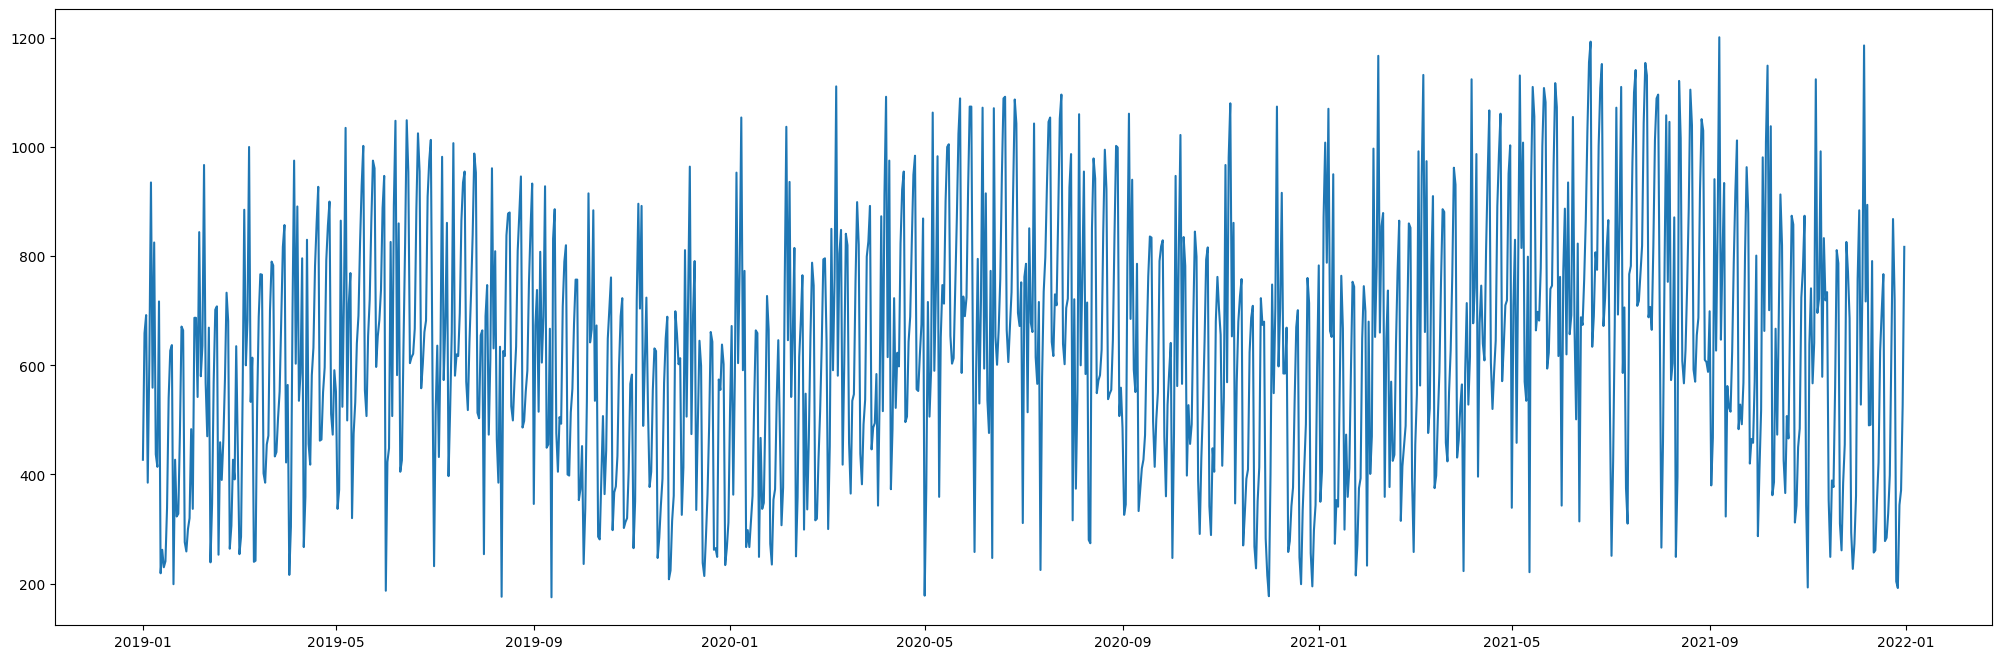

In [21]:
plt.figure(figsize=(25, 8))
plt.plot(dw_df)

In [22]:
# Days of the week
new_df['day'] = new_df.date.dt.day_name()
day_name = list(calendar.day_name)

w_df = new_df.groupby('day')['item_count'].sum()
w_df = w_df.loc[day_name].squeeze()

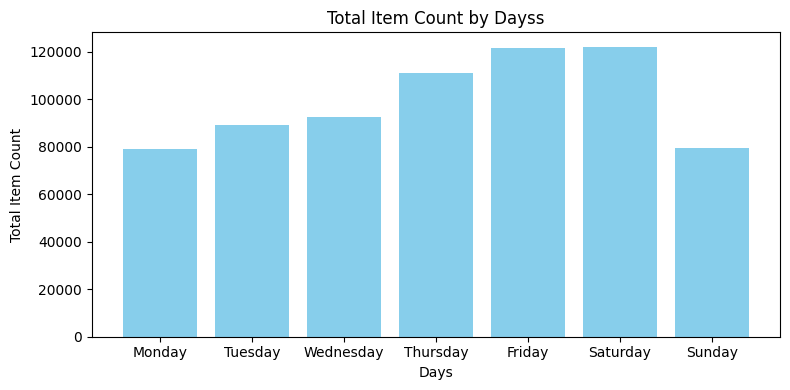

In [23]:
plt.figure(figsize=(8, 4))
plt.bar(day_name, w_df.values, color='skyblue')
plt.xlabel('Days')
plt.ylabel('Total Item Count')
plt.title('Total Item Count by Dayss')
plt.xticks()
plt.tight_layout()
plt.show()

In [24]:
# Month of the year
new_df['month'] = new_df.date.dt.month_name()
month_name = list(calendar.month_name)[1:]

m_df = new_df.groupby('month')['item_count'].sum()
m_df = m_df.loc[month_name].squeeze()

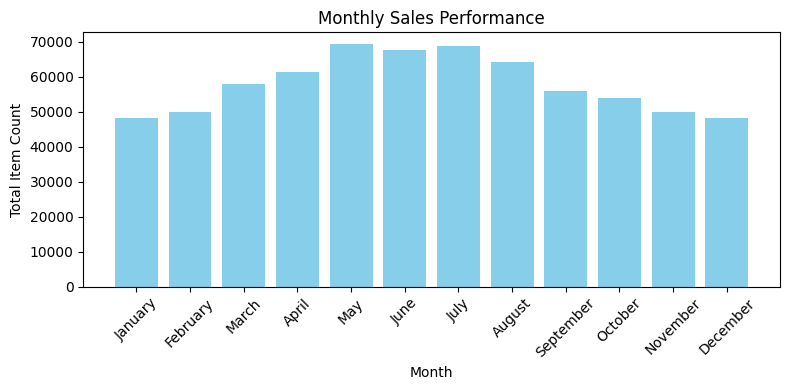

In [25]:
plt.figure(figsize=(8, 4))
plt.bar(month_name, m_df.values, color='skyblue')
plt.xlabel('Month')
plt.ylabel('Total Item Count')
plt.title('Monthly Sales Performance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
# Quarter wise
new_df['quarter'] = new_df['date'].dt.quarter

q_df = new_df.groupby('quarter')['item_count'].sum()

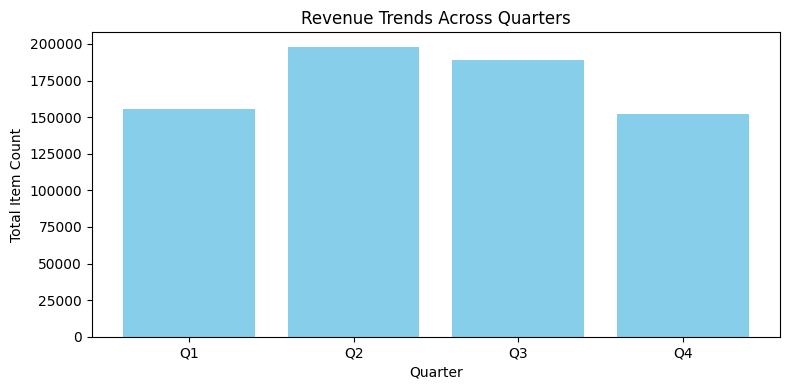

In [27]:
plt.figure(figsize=(8, 4))
plt.bar(q_df.index, q_df.values, color='skyblue')
plt.xlabel('Quarter')
plt.ylabel('Total Item Count')
plt.title('Revenue Trends Across Quarters')
plt.xticks(q_df.index, ['Q1', 'Q2', 'Q3', 'Q4'], rotation=0)
plt.tight_layout()
plt.show()

In [28]:
# By year
new_df['year'] = new_df['date'].dt.year
new_df['quarter-year'] = "Q" + new_df['quarter'].astype(str) + "-" + new_df['year'].astype('str')

order = ['Q{}-{}'.format(q, y) for y in range(2019, 2022) for q in range(1, 5)]
y_df = new_df.groupby('quarter-year')['item_count'].sum()
y_df = y_df.loc[order].squeeze()

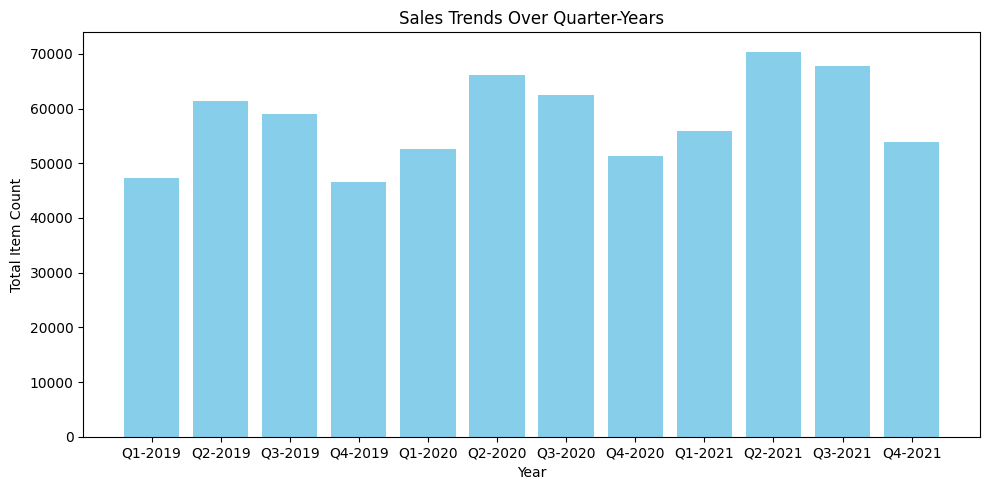

In [29]:
plt.figure(figsize=(10, 5))
plt.bar(y_df.index, y_df.values, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Total Item Count')
plt.title('Sales Trends Over Quarter-Years')
plt.tight_layout()
plt.show()

Comparing the performances of the different restaurants

The restaurant with the highest sales is Bob's Diner with total sales of $6337275.69.


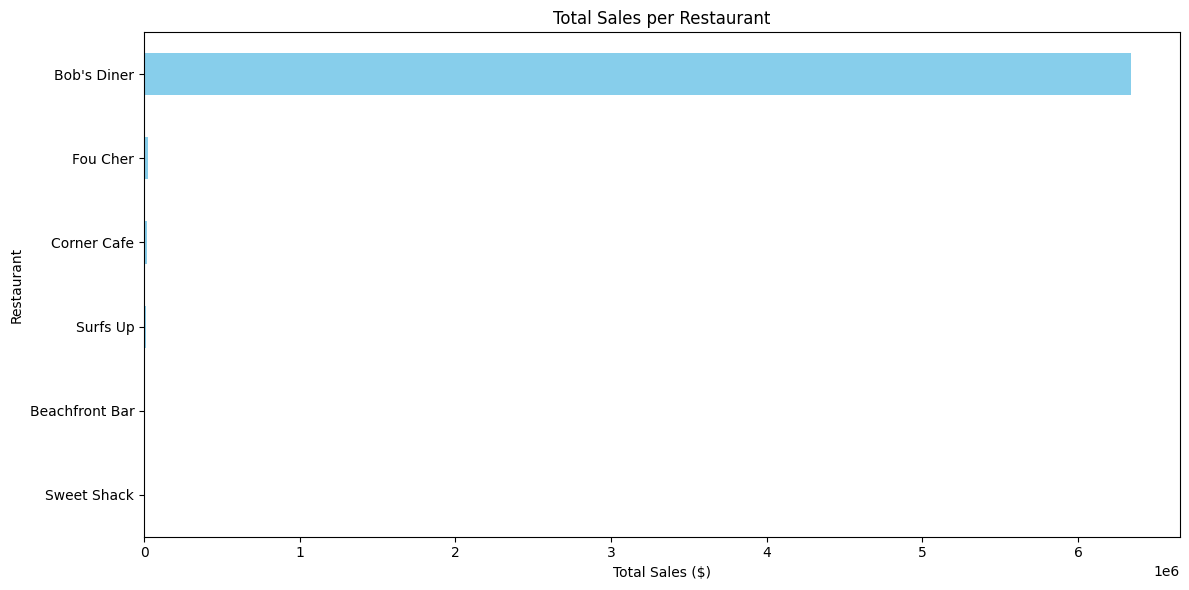

In [30]:
total_sales_per_restaurant = new_df.groupby('restaurants_name')['price'].sum()

top_restaurant = total_sales_per_restaurant.idxmax()
max_sales = total_sales_per_restaurant.max()

print(f"The restaurant with the highest sales is {top_restaurant} with total sales of ${max_sales:.2f}.")

plt.figure(figsize=(12, 6))
total_sales_per_restaurant.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Total Sales ($)')
plt.ylabel('Restaurant')
plt.title('Total Sales per Restaurant')
plt.tight_layout()
plt.show()

The total sales for Bob's Diner is 6337275.69


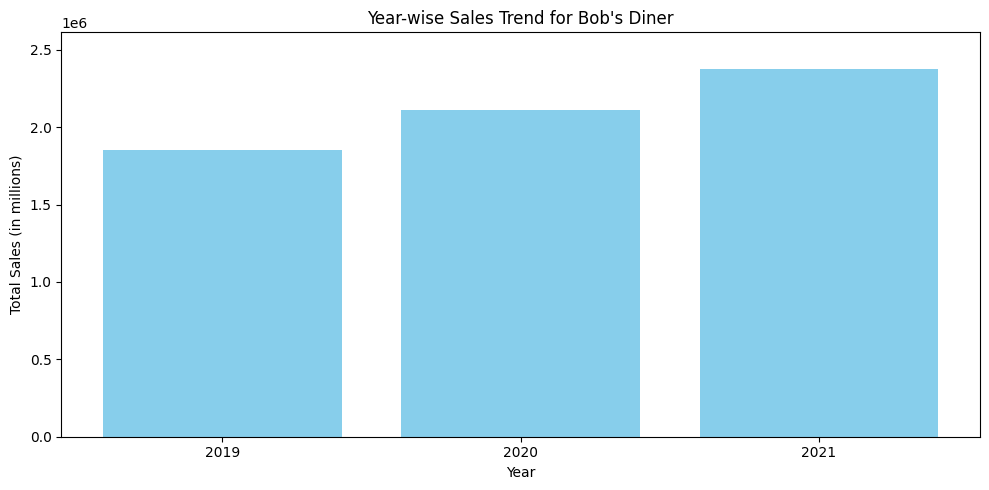

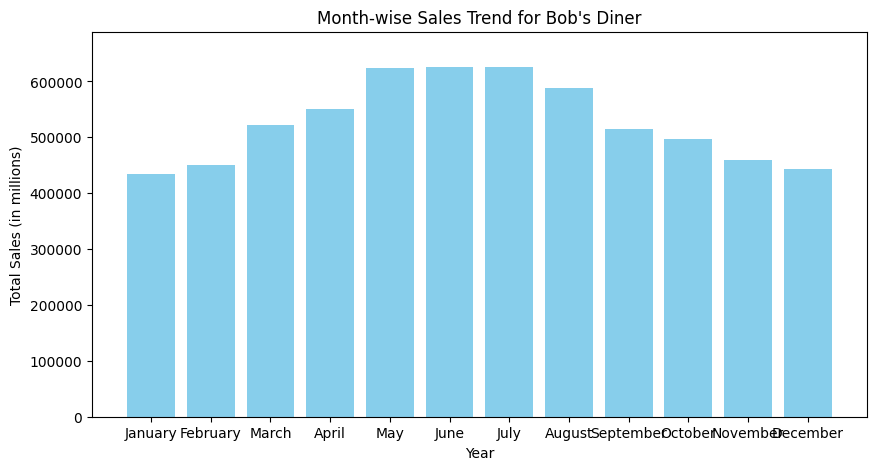

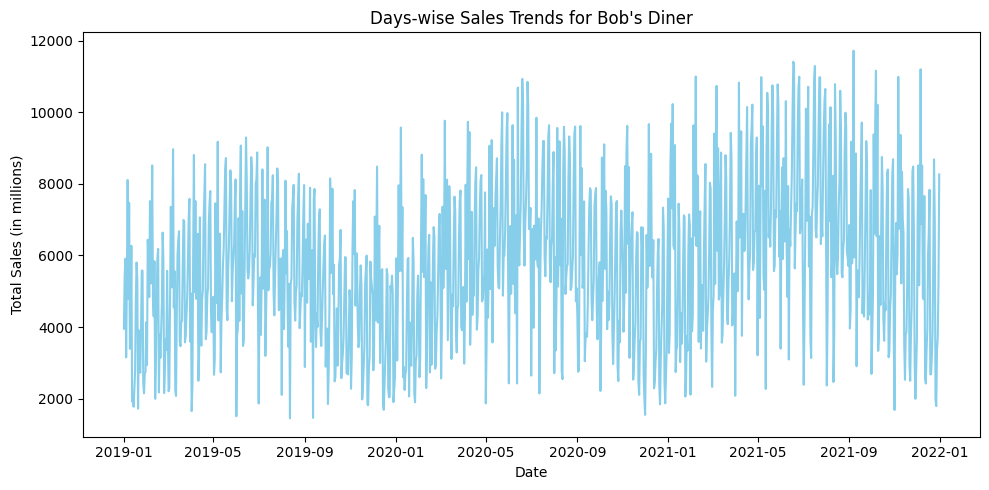




----------------------------------------------------------------------------------------------------
The total sales for Surfs Up is 15651.49


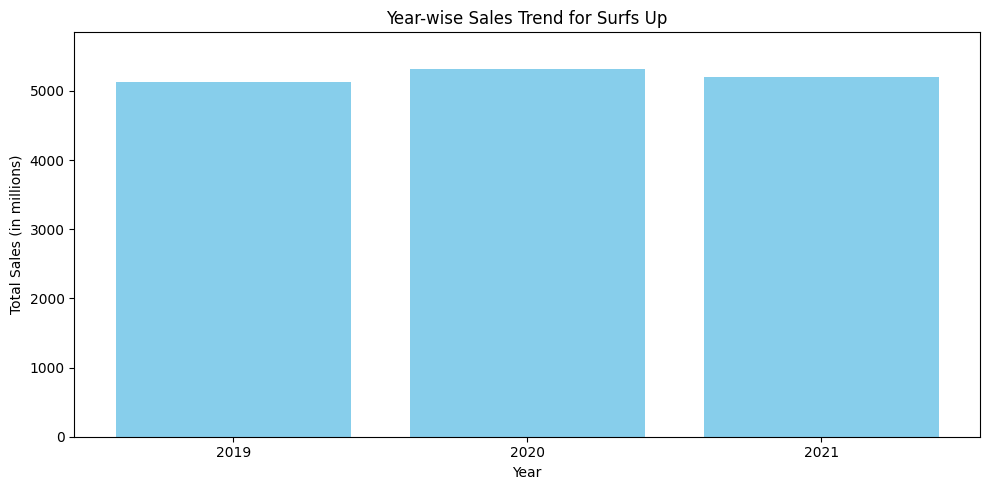

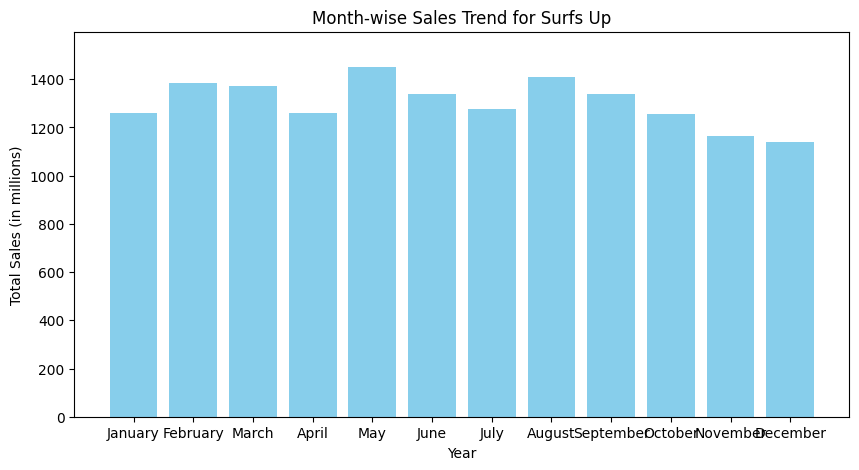

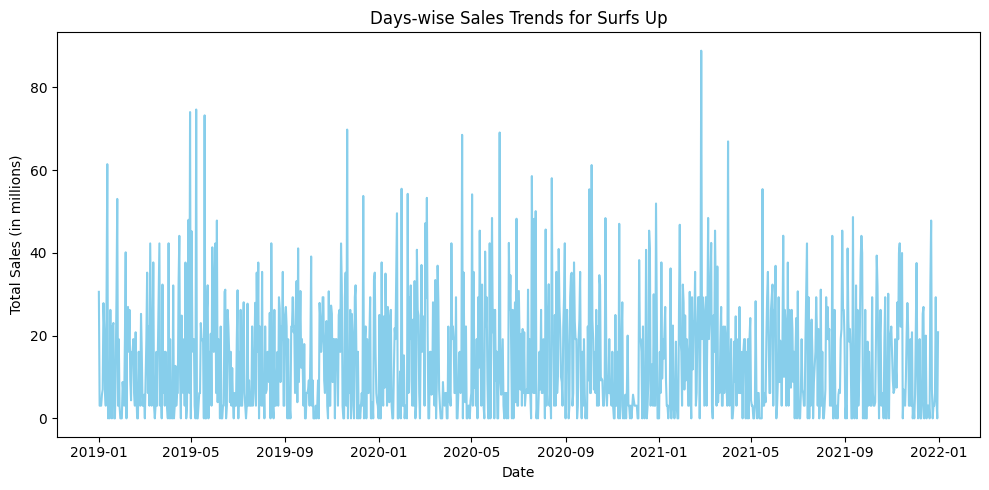




----------------------------------------------------------------------------------------------------
The total sales for Beachfront Bar is 3796.20


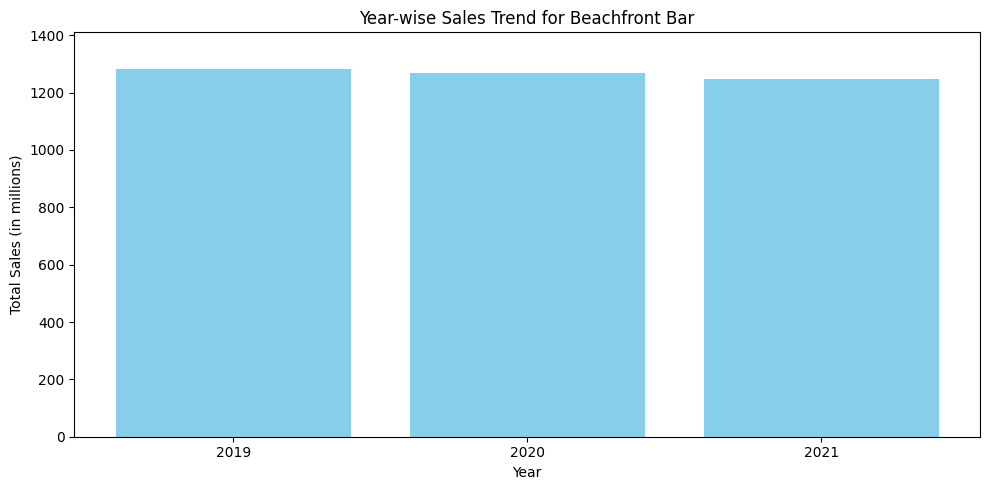

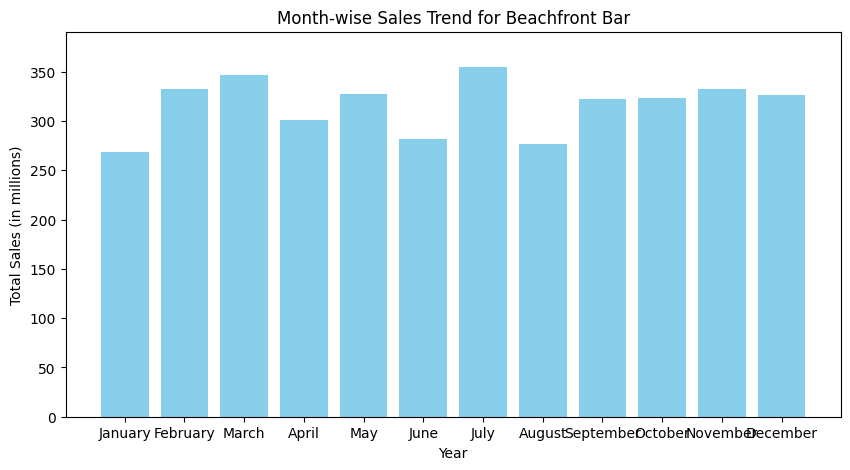

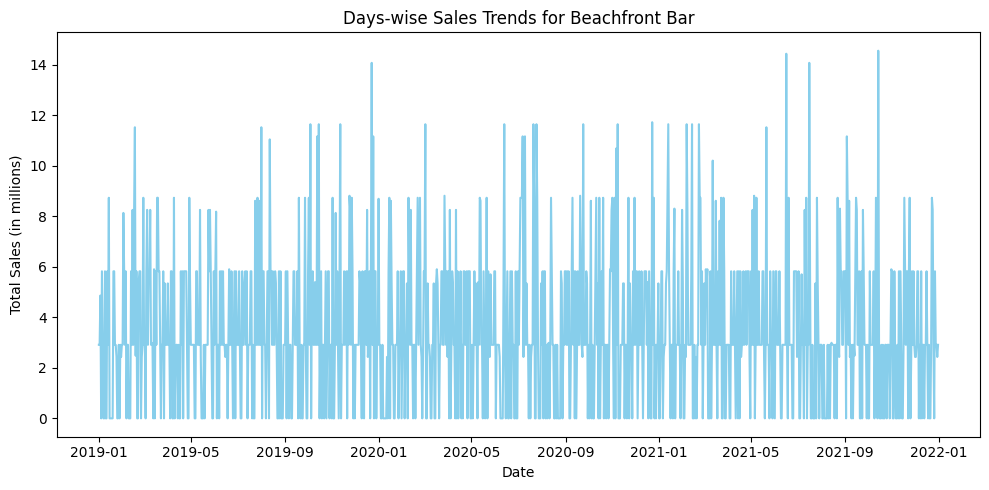




----------------------------------------------------------------------------------------------------
The total sales for Fou Cher is 27885.37


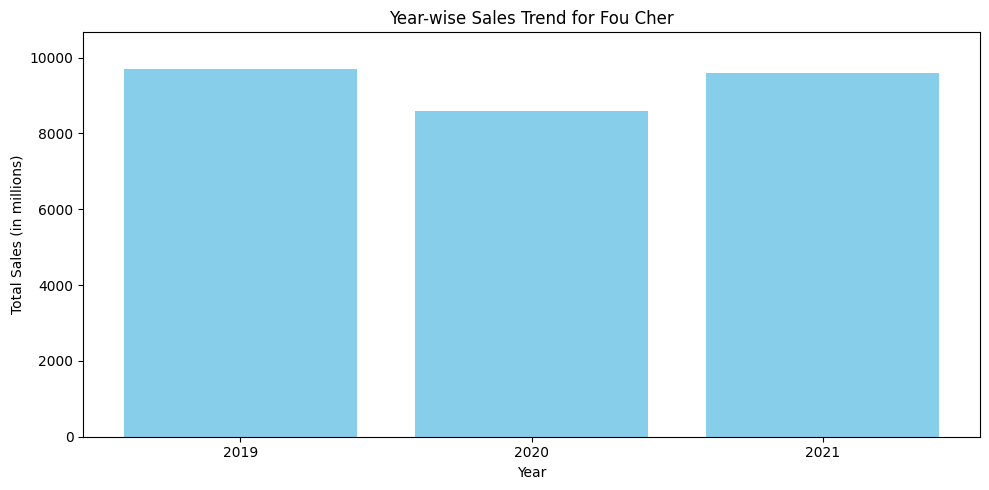

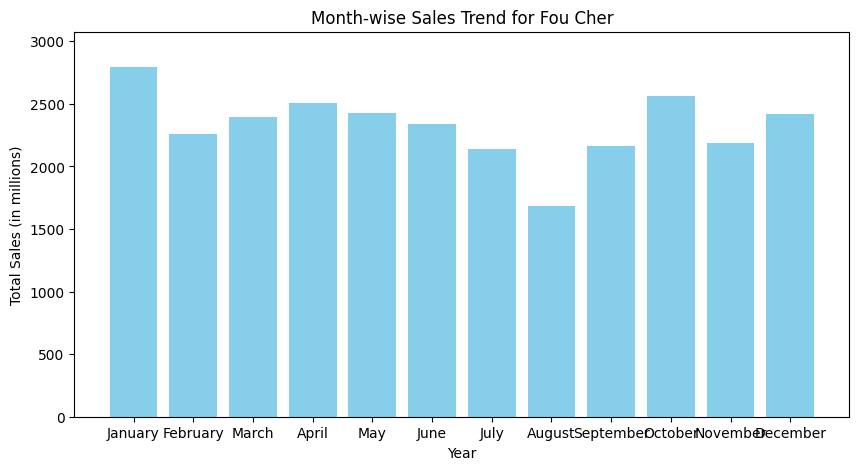

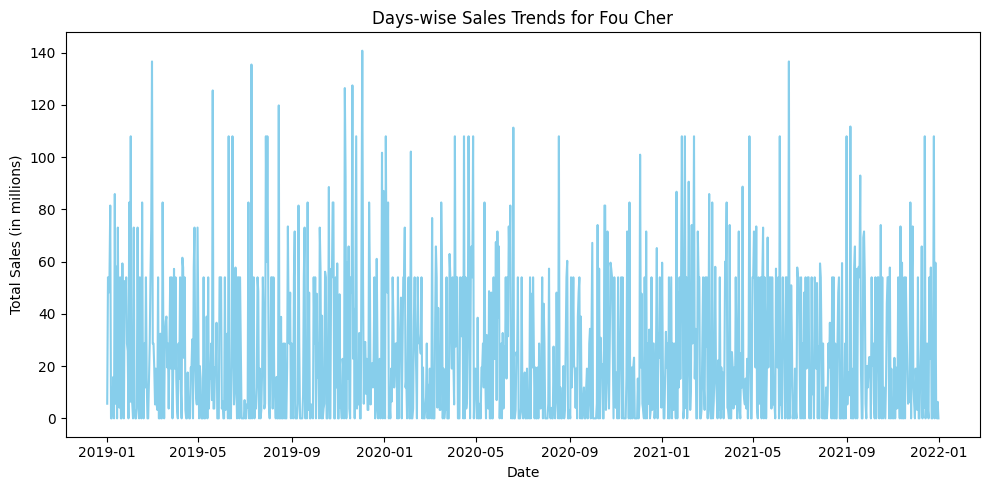




----------------------------------------------------------------------------------------------------
The total sales for Corner Cafe is 16551.43


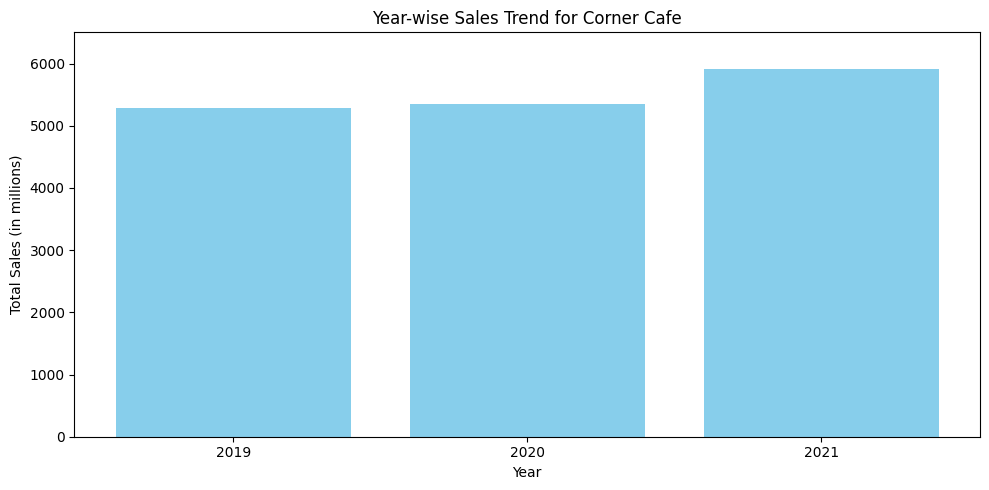

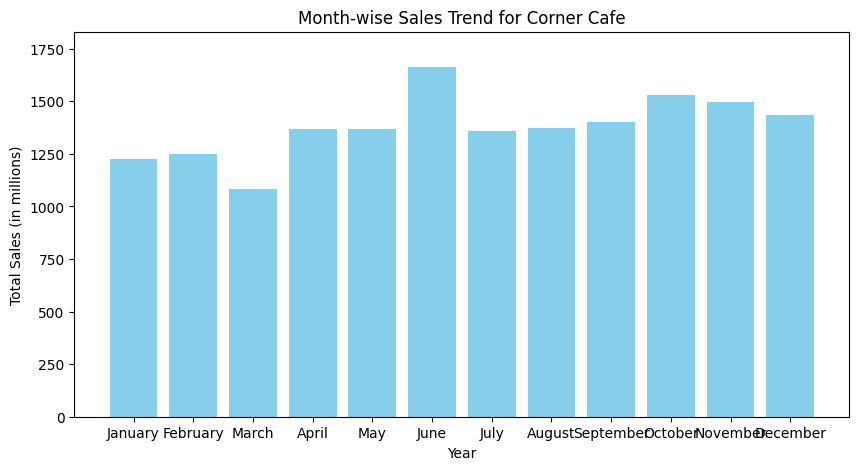

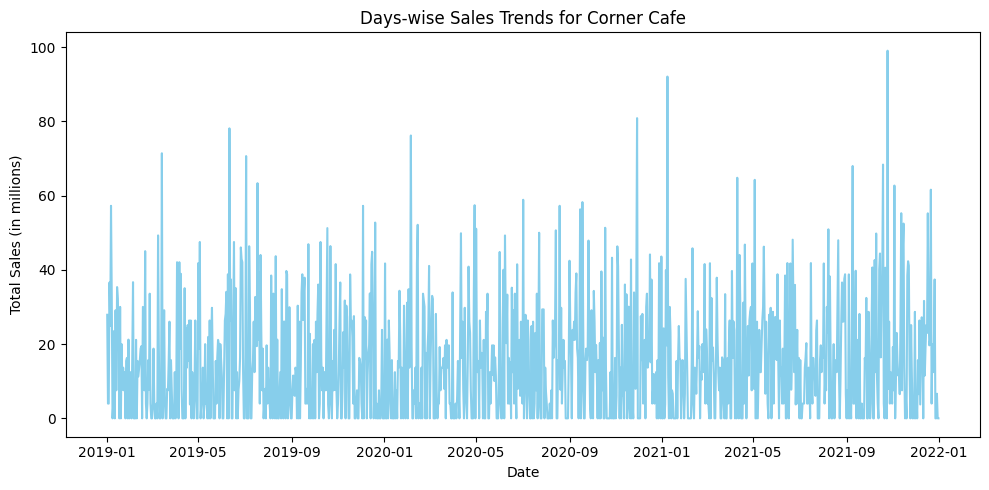




----------------------------------------------------------------------------------------------------
The total sales for Sweet Shack is 2578.27


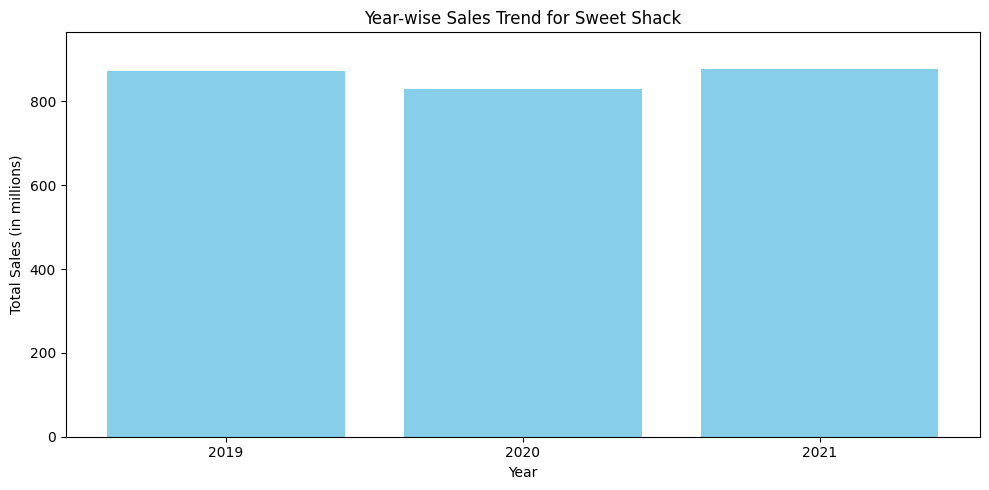

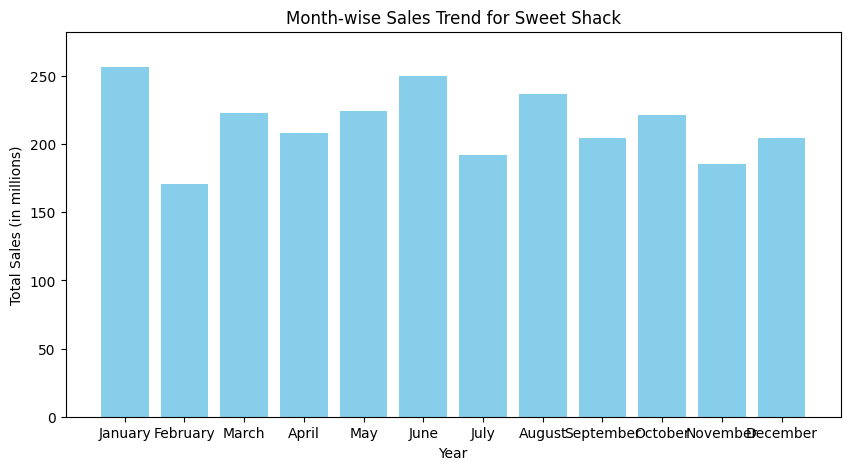

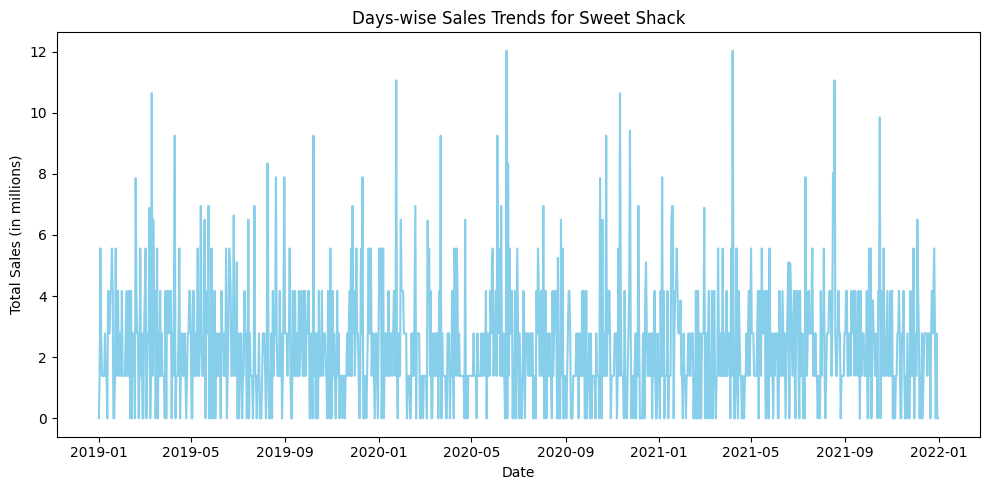




----------------------------------------------------------------------------------------------------


In [31]:
# Sales for each restaurant across different years, months, and days
for name in new_df['restaurants_name'].unique():

    filtered_df = new_df[new_df['restaurants_name'] == name]
    res_df = filtered_df.groupby('year')['price'].sum()
    
    print(f"The total sales for {name} is {res_df.sum():.2f}")
    
    plt.figure(figsize=(10, 5))
    plt.bar(res_df.index, res_df.values, color='skyblue')
    plt.xlabel('Year')
    plt.ylabel('Total Sales (in millions)')
    plt.title(f"Year-wise Sales Trend for {name}")
    plt.xticks(res_df.index, list(res_df.index))
    plt.ylim(0, res_df.values.max() * 1.1)
    plt.tight_layout()
    plt.show()
    

    
    res_df = filtered_df.groupby('month')['price'].sum()
    res_df = res_df.loc[month_name].squeeze()
    
    plt.figure(figsize=(10, 5))
    plt.bar(res_df.index, res_df.values, color='skyblue')
    plt.xlabel('Year')
    plt.ylabel('Total Sales (in millions)')
    plt.title(f"Month-wise Sales Trend for {name}")
    plt.xticks(res_df.index, list(res_df.index))
    plt.ylim(0, res_df.values.max() * 1.1)


    
    res_df = filtered_df.groupby('date')['price'].sum()
    
    plt.figure(figsize=(10, 5))
    plt.plot(res_df.index, res_df.values, color='skyblue')
    plt.xlabel('Date')
    plt.ylabel('Total Sales (in millions)')
    plt.title(f"Days-wise Sales Trends for {name}")
    plt.tight_layout()
    plt.show()
    print("\n\n\n" + "-"*100)

In [32]:
# Most popular Item
item_df = new_df.groupby('item_id')['item_count'].sum()
popular_item = items[items['id'] == item_df.idxmax()]['name'].iloc[0]
print(f"The most popular item is {popular_item}")

The most popular item is Strawberry Smoothy


In [33]:
# Most popular item is sold in these stores
print(f"The most popular items is sold in these stores: {new_df[new_df['item_name'] == popular_item]['restaurants_name'].unique()}")

The most popular items is sold in these stores: ["Bob's Diner"]


In [34]:
# Most popular item is sold in all the stores are
for name in new_df['restaurants_name'].unique():

    filtered_df = new_df[new_df['restaurants_name'] == name]
    res_df = filtered_df.groupby('item_id')['item_count'].sum()
    most_popular = items[items['id'] == res_df.idxmax()]['name'].iloc[0]
    print(f"The most popular items is sold in {name} is  {most_popular}")

The most popular items is sold in Bob's Diner is  Strawberry Smoothy
The most popular items is sold in Surfs Up is  Awesome Soft Drink
The most popular items is sold in Beachfront Bar is  Fantastic Milky Smoothy
The most popular items is sold in Fou Cher is  Blue Ribbon Fruity Vegi Lunch
The most popular items is sold in Corner Cafe is  Frozen Milky Smoothy
The most popular items is sold in Sweet Shack is  Awesome Smoothy


In [35]:
# Checking if  the store with the highest sales volume is also making the most money per day
highest_sales_store = new_df.groupby('restaurants_name')['price'].sum()
print(f"The store with the highest sales is {highest_sales_store.idxmax()} with total sales of {highest_sales_store.max()}\n")


for name in new_df['restaurants_name'].unique():
    sales_per_day = new_df[new_df['restaurants_name'] == name].groupby('date')['price'].sum()
    print(f"The highest money per day of {name} is {sales_per_day.max():.2f}")

The store with the highest sales is Bob's Diner with total sales of 6337275.69

The highest money per day of Bob's Diner is 11719.97
The highest money per day of Surfs Up is 88.84
The highest money per day of Beachfront Bar is 14.55
The highest money per day of Fou Cher is 140.72
The highest money per day of Corner Cafe is 99.04
The highest money per day of Sweet Shack is 12.03


Yes the store with the highest sales volume is also making the most money per day.

In [36]:
# Checking if  all prices are unique
all_prices_unique = items['cost'].nunique() == len(items['cost'])

if all_prices_unique:
    print("All prices are unique.")
else:
    print("There are duplicate prices.")

All prices are unique.


In [37]:
# Most expensive item at each restaurant and find out its calorie count
new_df['cost_per_unit'] = new_df['price']/new_df['item_count']

for name in new_df['restaurants_name'].unique():
    cost = round(new_df[new_df['restaurants_name'] == name]['cost_per_unit'].max(), 2)
    item_name = items[items['cost'] == cost]['name'].iloc[0]
    item_kcal = items[items['cost'] == cost]['kcal'].iloc[0]
    print(f"The most expensive item in {name} is {item_name} and it's calorie count is {item_kcal} kcal.")

The most expensive item in Bob's Diner is Sweet Fruity Cake and it's calorie count is 931 kcal.
The most expensive item in Surfs Up is Steak Meal and it's calorie count is 607 kcal.
The most expensive item in Beachfront Bar is Sweet Vegi Soft Drink and it's calorie count is 538 kcal.
The most expensive item in Fou Cher is Blue Ribbon Fruity Vegi Lunch and it's calorie count is 881 kcal.
The most expensive item in Corner Cafe is Pike Lunch and it's calorie count is 653 kcal.
The most expensive item in Sweet Shack is Blue Ribbon Milky Cake and it's calorie count is 612 kcal.


Forecasting using machine learning algorithms

In [38]:
time_series = new_df.groupby('date').agg({'item_count': 'sum',
                                         'day': lambda x: x.unique()[0],
                                         'month': lambda x: x.unique()[0],
                                         'year': lambda x: x.unique()[0],
                                        'quarter': lambda x: x.unique()[0]})

In [39]:
time_series['day_year'] = time_series.index.day_of_year
time_series['day_month'] = time_series.index.day
time_series['week_num'] = time_series.index.isocalendar().week.astype(int)

In [40]:
encoder = OrdinalEncoder(categories=[month_name, day_name])

encoder.fit(time_series[['month', 'day']])

time_series[['month', 'day']] = encoder.transform(time_series[['month', 'day']])

In [41]:
time_series.head()

,item_count,day,month,year,quarter,day_year,day_month,week_num
date,,,,,,,,
2019-01-01,427,1.0,0.0,2019,1,1,1,1
2019-01-02,659,2.0,0.0,2019,1,2,2,1
2019-01-03,692,3.0,0.0,2019,1,3,3,1
2019-01-04,385,4.0,0.0,2019,1,4,4,1
2019-01-05,610,5.0,0.0,2019,1,5,5,1


In [42]:
train = time_series[time_series.index < '2021-07-01']
test = time_series[time_series.index >= '2021-07-01']

In [43]:
x_var = time_series.drop(columns='item_count').columns
y_var = 'item_count'

In [44]:
X_train = train[x_var]
y_train = train[y_var]

X_test = test[x_var]
y_test = test[y_var]

In [45]:
#  Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [46]:
test['lr_pred'] = lr.predict(X_test)

C:\Users\rohit\AppData\Local\Temp\ipykernel_16892\3421247276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['lr_pred'] = lr.predict(X_test)


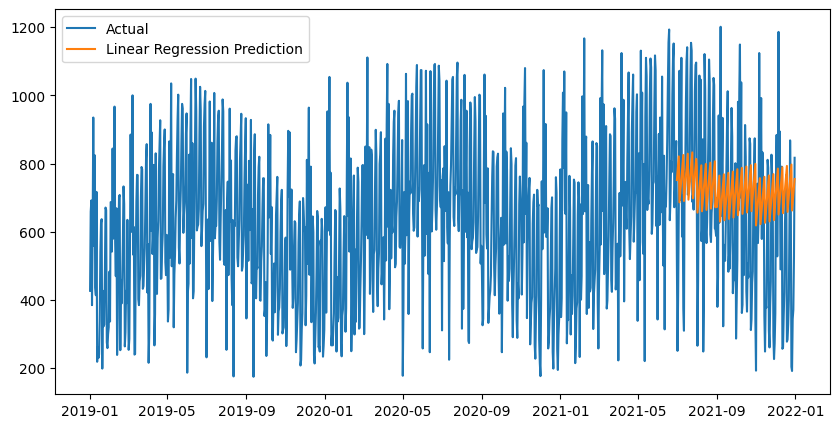

In [47]:
plt.figure(figsize=(10, 5))

plt.plot(time_series.item_count, label="Actual")
plt.plot(test.lr_pred, label = "Linear Regression Prediction")
plt.legend()
plt.show()

In [48]:
lr_rmse = rmse(y_true=test.item_count, y_pred=test.lr_pred)
lr_mae = mae(y_true=test.item_count, y_pred=test.lr_pred)
lr_r2 = r2(y_true=test.item_count, y_pred=test.lr_pred)

print(f"Linear Regression: \nRMSE: {lr_rmse:.2f}\nMAE: {lr_mae:.2f}\nR2_Score: {lr_r2*100:.2f}")

Linear Regression: 
RMSE: 255.72
MAE: 210.56
R2_Score: 0.19


In [49]:
results = pd.DataFrame([lr_rmse, lr_mae,lr_r2*100], index = ['RMSE', 'MAE', 'R2_Score'], columns = ['Linear Regression']).round(2)
results

,Linear Regression
RMSE,255.72
MAE,210.56
R2_Score,0.19


In [50]:
#  Random Forest Regressor
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [51]:
test['rfr_pred'] = rfr.predict(X_test)

C:\Users\rohit\AppData\Local\Temp\ipykernel_16892\1347000322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['rfr_pred'] = rfr.predict(X_test)


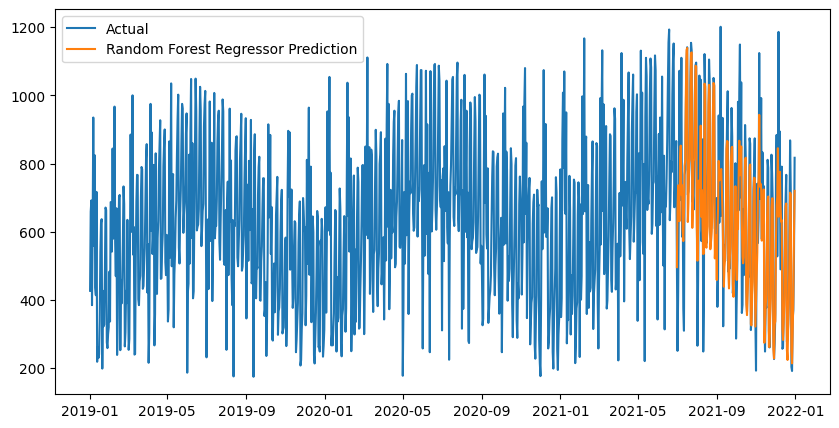

In [52]:
plt.figure(figsize=(10, 5))

plt.plot(time_series.item_count, label="Actual")
plt.plot(test.rfr_pred, label = "Random Forest Regressor Prediction")
plt.legend()
plt.show()

In [53]:
rfr_rmse = rmse(y_true=test.item_count, y_pred=test.rfr_pred)
rfr_mae = mae(y_true=test.item_count, y_pred=test.rfr_pred)
rfr_r2 = r2(y_true=test.item_count, y_pred=test.rfr_pred)

print(f"Random Forest Regressor: \nRMSE: {rfr_rmse:.2f}\nMAE: {rfr_mae:.2f}\nR2_Score: {rfr_r2*100:.2f}")

Random Forest Regressor: 
RMSE: 138.68
MAE: 94.93
R2_Score: 70.65


In [54]:
results['Random Forest'] = [rfr_rmse,rfr_mae,rfr_r2*100]
results.round(2)

,Linear Regression,Random Forest
RMSE,255.72,138.68
MAE,210.56,94.93
R2_Score,0.19,70.65


In [55]:
#  XGBRegressor
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [56]:
test['xgbr_pred'] = xgbr.predict(X_test)

C:\Users\rohit\AppData\Local\Temp\ipykernel_16892\2778341108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['xgbr_pred'] = xgbr.predict(X_test)


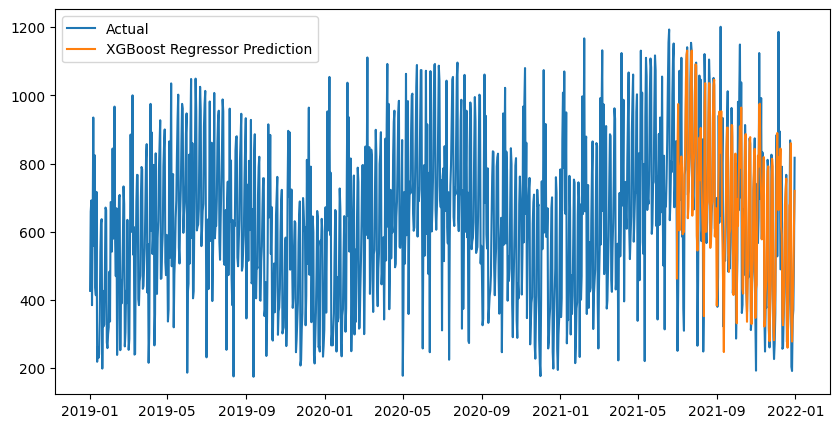

In [57]:
plt.figure(figsize=(10, 5))

plt.plot(time_series.item_count, label="Actual")
plt.plot(test.xgbr_pred, label = "XGBoost Regressor Prediction")
plt.legend()
plt.show()

In [58]:
xgbr_rmse = rmse(y_true=test.item_count, y_pred=test.xgbr_pred)
xgbr_mae = mae(y_true=test.item_count, y_pred=test.xgbr_pred)
xgbr_r2 = r2(y_true=test.item_count, y_pred=test.xgbr_pred)

print(f"XGBoost Regressor: \nRMSE: {xgbr_rmse:.2f}\nMAE: {xgbr_mae:.2f}\nR2_Score: {xgbr_r2*100:.2f}")

XGBoost Regressor: 
RMSE: 153.44
MAE: 103.43
R2_Score: 64.06


In [59]:
results['XGBoost'] = [xgbr_rmse,xgbr_mae,xgbr_r2*100]
results = results.round(2)

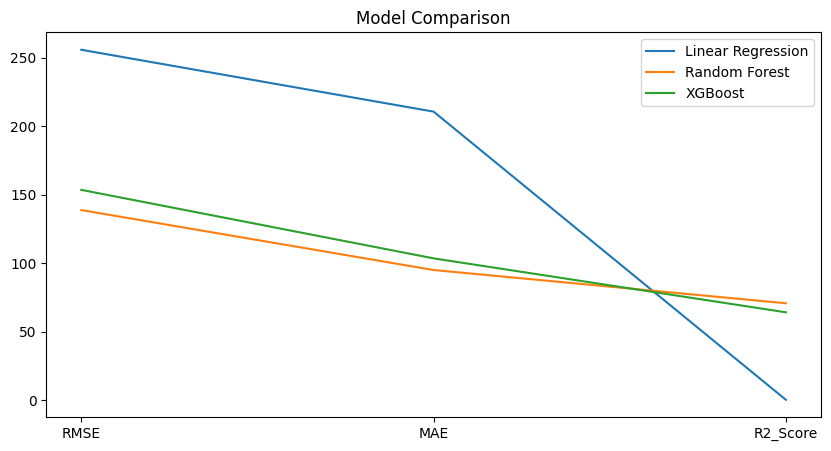

In [60]:
plt.figure(figsize = (10,5))
plt.plot(results['Linear Regression'], label = "Linear Regression")
plt.plot(results['Random Forest'], label = "Random Forest")
plt.plot(results['XGBoost'], label = "XGBoost")
plt.legend(loc = "upper right")
plt.title("Model Comparison")
plt.show()


In [61]:
results

,Linear Regression,Random Forest,XGBoost
RMSE,255.72,138.68,153.44
MAE,210.56,94.93,103.43
R2_Score,0.19,70.65,64.06


Random Forest Regressor as it achived a higher R2 Score, lowest RMSE, and lowest MAE. Even though the R2 Score is way above 1.0. Form these three model Random Forest Regressor perfomed the best

In [62]:
# Forcast for the next year using the best model
forecast_periods = 365 
last_date = time_series.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, forecast_periods + 1)]

X_forecast = pd.DataFrame(index=future_dates, columns=x_var)

X_forecast['day'] = X_forecast.index.day
X_forecast['quarter'] = X_forecast.index.quarter
X_forecast['year'] = X_forecast.index.year
X_forecast['month'] = X_forecast.index.month_name()
X_forecast['day_year'] = X_forecast.index.day_of_year
X_forecast['day_month'] = X_forecast.index.day
X_forecast['week_num'] = X_forecast.index.isocalendar().week

# Define the months in the order you want
month_name = list(X_forecast['month'].unique())

# Initialize the OrdinalEncoder
encoder = OrdinalEncoder(categories=[month_name])

# Fit the encoder to the 'month' column (reshaped to a DataFrame)
encoder.fit(X_forecast[['month']])

# Transform the 'month' column using the fitted encoder
X_forecast['month'] = encoder.transform(X_forecast[['month']])

forecast_values = rfr.predict(X_forecast)

forecast_df = pd.DataFrame(index=future_dates, data=forecast_values, columns=['rfr_pred'])

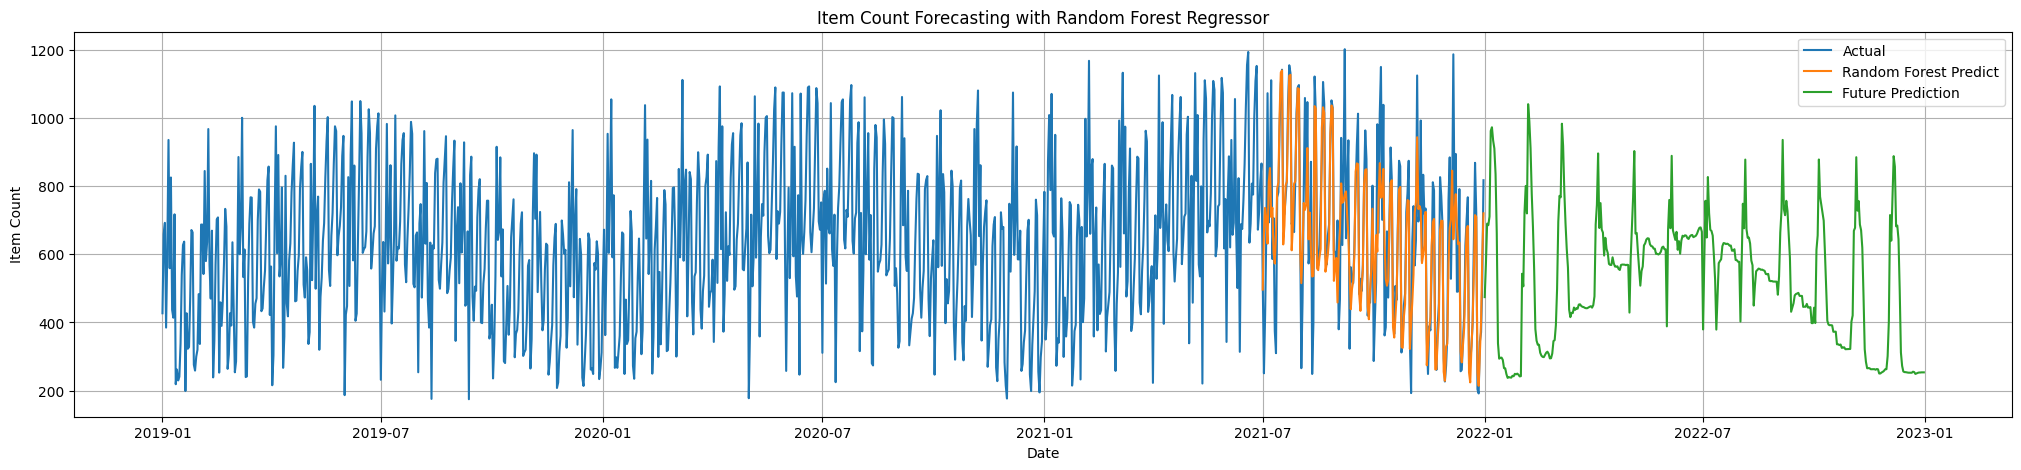

In [63]:
plt.figure(figsize = (25,5))
plt.plot(time_series.item_count, label = "Actual")
plt.plot(test.rfr_pred, label = "Random Forest Predict")
plt.plot(forecast_df.rfr_pred, label = "Future Prediction")

plt.title('Item Count Forecasting with Random Forest Regressor')
plt.xlabel('Date')
plt.ylabel('Item Count')

plt.legend()
plt.grid(True)

plt.show()

Forecasting using deep learning algorithms

In [64]:
# Using sales amount for prediction
lstm_df = new_df.groupby('date').agg({'price': 'sum'})

In [65]:
# train and test series
train = lstm_df[lstm_df.index < '2021-07-01']
test = lstm_df[lstm_df.index >= '2021-07-01']

In [66]:
# Generating Synthetic Data
mean_price = lstm_df['price'].mean()
std_dev_price = lstm_df['price'].std()
autocorrelation = lstm_df['price'].autocorr()

start_date = pd.Timestamp('2022-01-01')
end_date = pd.Timestamp('2022-12-31')

date_range = pd.date_range(start=start_date, end=end_date)

synthetic_prices = np.zeros(len(date_range))
synthetic_prices[0] = mean_price + np.random.randn() * std_dev_price  # Initial price

for i in range(1, len(date_range)):
    synthetic_prices[i] = mean_price + autocorrelation * (synthetic_prices[i-1] - mean_price) + np.random.randn() * std_dev_price

synthetic_df = pd.DataFrame({
    'date': date_range,
    'price': synthetic_prices
})

synthetic_df.set_index('date', inplace=True)

Here we have created synthetic data for 12 months. As we don't need more data(we already have three years of data). And in the Project Task It was unclear what to do with it.

In [67]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [68]:
length=12
n_features=1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [69]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [70]:
# Using HPT to find the best combination of layers and units
def build_lstm_model(hp):
    model = Sequential()
    num_layers = hp.Int('num_layers', min_value=1, max_value=5, default=1)
    
    for i in range(num_layers):
        if i == 0:
            model.add(LSTM(units=hp.Int(f'units_{i}', min_value=50, max_value=200, step=10),
                           input_shape=(length, scaled_train.shape[1]),  # Assuming shape[1] is number of features
                           return_sequences=True if num_layers > 1 else False))
        elif i == num_layers - 1:
            model.add(LSTM(units=hp.Int(f'units_{i}', min_value=50, max_value=200, step=10)))
        else:
            model.add(LSTM(units=hp.Int(f'units_{i}', min_value=50, max_value=200, step=10), return_sequences=True))
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    return model

tuner = RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,
    directory='my_dir',
    project_name='lstm_hyperparameters')

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

tuner.search(generator, epochs=100, validation_data=validation_generator, callbacks=[early_stopping])

best_hp = tuner.get_best_hyperparameters()[0]
best_model = build_lstm_model(best_hp)

Reloading Tuner from my_dir\lstm_hyperparameters\tuner0.json


D:\Projects\venv\ml\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [71]:
best_model.fit(generator,epochs=100, validation_data=validation_generator,callbacks=[early_stopping])

Epoch 1/100
 14/900 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.1319 

D:\Projects\venv\ml\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


900/900 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0568 - val_loss: 0.0603
Epoch 2/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0475 - val_loss: 0.0494
Epoch 3/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0402 - val_loss: 0.0482
Epoch 4/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0387 - val_loss: 0.0446
Epoch 5/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0383 - val_loss: 0.0440
Epoch 6/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0356 - val_loss: 0.0526
Epoch 7/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0345 - val_loss: 0.0410
Epoch 8/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0334 - val_loss: 0.0357
Epoch 9/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0314 - val_loss: 0.0385
Epoch 10/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0319 - val_loss: 0.0382


<Axes: >

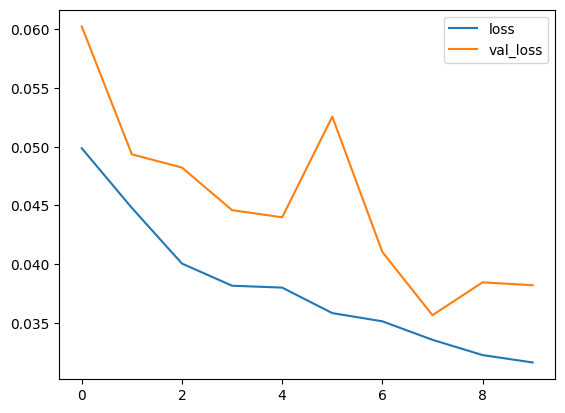

In [72]:
# losses = pd.DataFrame(best_model.history.history)
losses = pd.DataFrame(best_model.history.history)

losses.plot()

In [73]:
# testing the results
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    # current_pred = best_model.predict(current_batch)[0]
    current_pred = best_model.predict(current_batch)[0]
    # store prediction
    test_predictions.append(current_pred)
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [74]:
true_predictions = scaler.inverse_transform(test_predictions)

In [75]:
test['Predictions'] = true_predictions

C:\Users\rohit\AppData\Local\Temp\ipykernel_16892\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


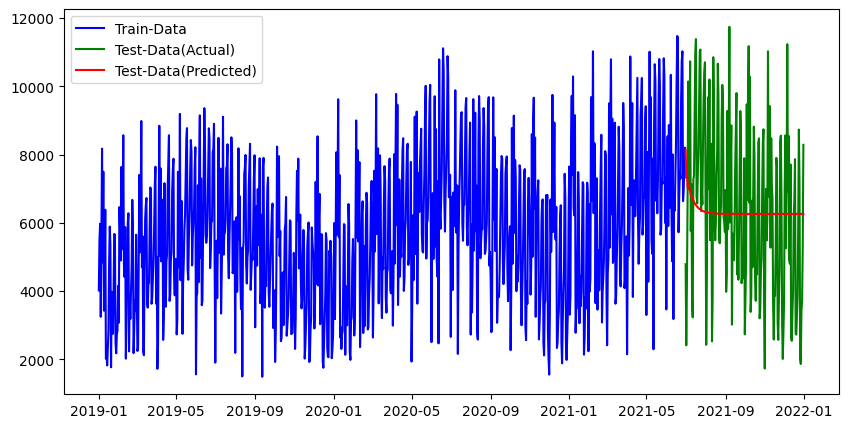

In [77]:
plt.figure(figsize = (10,5))
plt.plot(train, color = 'blue', label = 'Train-Data')
plt.plot(test.price, color = 'green', label = 'Test-Data(Actual)')
plt.plot(test.index, test.Predictions,color = 'red', label = 'Test-Data(Predicted)')
plt.legend()
plt.show()

In [78]:
# Calculate the mean absolute percentage error (MAPE) 
mape_lstm = mape(y_true = test.price, y_pred = test.Predictions)
print(f"MAPE of the model : {mape_lstm:.3f}")

MAPE of the model : 0.419


The model's constant predictions, lack of variance reflecting actual sales, and potential issues with complexity and insufficient training data suggest it struggles to capture sales variability and temporal patterns effectively.

In [79]:
# Model using the entire series for training
scaler_ = MinMaxScaler()
scaler_.fit(lstm_df)
full_lstm = scaler.transform(lstm_df)

In [80]:
length=3
full_generator = TimeseriesGenerator(full_lstm, full_lstm, length=length, batch_size=1)

In [81]:
# Getting 93 rather than 90 to ensure that the prediction is for 90 rows
forecast_dataset = synthetic_df[:93]

In [82]:
forecast_scaled = scaler_.transform(forecast_dataset)

length=3
forecast_generator = TimeseriesGenerator(forecast_scaled, forecast_scaled, length=length, batch_size=1)

In [83]:
best_model_full = build_lstm_model(best_hp)

D:\Projects\venv\ml\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [84]:
best_model_full.fit(full_generator, callbacks=[early_stopping])

  40/1093 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1878

D:\Projects\venv\ml\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1093/1093 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0679


D:\Projects\venv\ml\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


In [85]:
predictions = best_model_full.predict(forecast_generator)

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [86]:
predictions_original_scale = scaler_.inverse_transform(predictions)

In [87]:
forecast_dataset = forecast_dataset.iloc[:-3]
forecast_dataset['forecasted_price'] = predictions_original_scale.flatten()

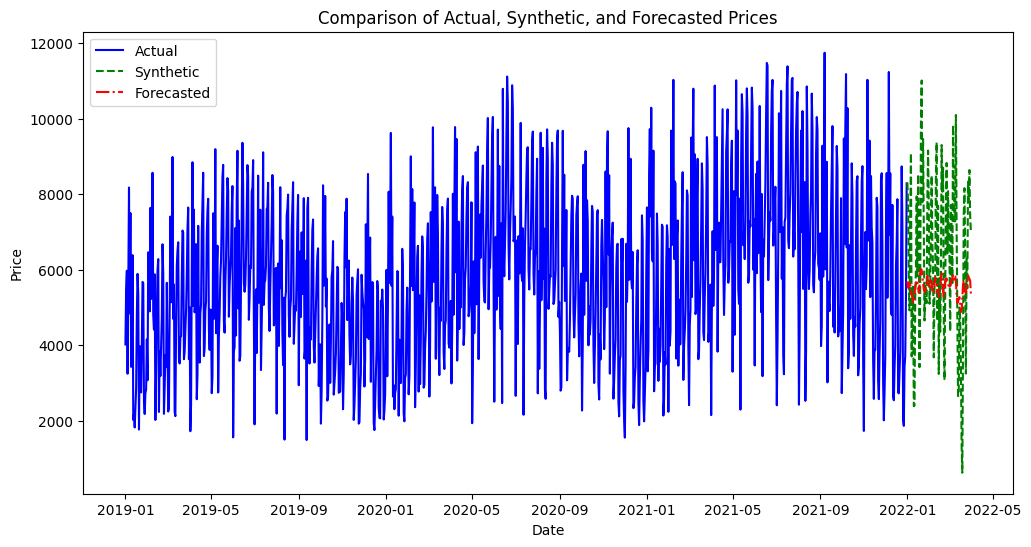

In [88]:
plt.figure(figsize=(12, 6))

plt.plot(lstm_df.index, lstm_df['price'], label='Actual', color='blue')

plt.plot(forecast_dataset.index[:90], forecast_dataset['price'], label='Synthetic', color='green', linestyle='--')

plt.plot(forecast_dataset.index[:90], forecast_dataset['forecasted_price'], label='Forecasted', color='red', linestyle='-.') 

plt.title('Comparison of Actual, Synthetic, and Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()